# Demand Forecast Predictor Model

## Business Understanding


#### **Introduction**

This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.

#### **Objectives**



Understand the data: The first objective is to gain insights into the store sales data, including store-specific information, product families, promotions, and sales numbers. This understanding will enable the company to make informed business decisions.

Predict store sales: Develop a reliable time series forecasting model that accurately predicts the unit sales for different product families at various Favorita stores. This will help the company optimize inventory management, plan promotions, and improve overall sales performance.

### **Hypothesis**

The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Null Hypothesis (H0): The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternative Hypothesis (H1): The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

### **Analytical Questions**



1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year?
3. Analyze the impact of the earthquake on sales
4. Determine if certain groups of stores sell more products
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?
7. Are there certain product families types that exhibit higher sales performance?
8. How does the sales trend vary across different store numbers?
9. What is the difference between RMSLE, RMSE, MSE


### Import Relevant Packages

In [2]:

# Data Handling
import pyodbc
from dotenv import dotenv_values
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches # type: ignore
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from scipy.stats import ttest_ind
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

import warnings
warnings.filterwarnings('ignore')


In [3]:

# Load environment variables from .env file into a dictionary
env_file = ".env"  # Specify the .env file path if it's not in the same directory
environment_variables = dotenv_values(env_file)

# Print the loaded environment variables for debugging
print("Environment variables:", environment_variables)

# Get the values for the environment variables
server = environment_variables.get("server")
login = environment_variables.get("login")
password = environment_variables.get("password")
database = environment_variables.get("database")

# Print the environment variables for debugging
print("Server:", server)
print("Login:", login)
print("Database:", database)

# Create a database connection string using pyodbc
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password}"
print("Connection string:", connection_string)

# Establish a connection to the database
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")
except Exception as e:
    print("Connection failed:", e)


Environment variables: OrderedDict([('server', 'dap-projects-database.database.windows.net'), ('login', 'learning_project_3'), ('password', 'A$uB1Lp3$2@24'), ('database', 'dapDB')])
Server: dap-projects-database.database.windows.net
Login: learning_project_3
Database: dapDB
Connection string: DRIVER={SQL Server};SERVER=dap-projects-database.database.windows.net;DATABASE=dapDB;UID=learning_project_3;PWD=A$uB1Lp3$2@24
Connection successful


In [11]:
'''
# Manually set the environment variables
os.environ["server"] = 'dap-projects-database.database.windows.net'
os.environ["login"] = 'learning_project_3'
os.environ["password"] = 'A$uBlLp3$2@24'
os.environ["database"] = 'dapDB'

# Load environment variables from os.environ
server = os.getenv("server")
login = os.getenv("login")
password = os.getenv("password")
database = os.getenv("database")

# Print the environment variables for debugging
print("Server:", server)
print("Login:", login)
print("Database:", database)

# Create a database connection string using pyodbc
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password}"
print("Connection string:", connection_string)

# Establish a connection to the database
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")
except Exception as e:
    print("Connection failed:", e)
'''

Server: dap-projects-database.database.windows.net
Login: learning_project_3
Database: dapDB
Connection string: DRIVER={SQL Server};SERVER=dap-projects-database.database.windows.net;DATABASE=dapDB;UID=learning_project_3;PWD=A$uBlLp3$2@24
Connection failed: ('08001', '[08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]SQL Server does not exist or access denied. (17) (SQLDriverConnect); [08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionOpen (Connect()). (53)')


In [4]:

# Query the first table 'oil' in the database
query1 = 'SELECT * FROM dbo.oil'
oil_df = pd.read_sql(query1, connection)

# Query the second table 'holidays_events' in the database
query2 = 'SELECT * FROM dbo.holidays_events'
holidays_events_df = pd.read_sql(query2, connection)

# Query the third table 'stores' in the database
query3 = 'SELECT * FROM dbo.stores'
stores_df = pd.read_sql(query3, connection)

In [5]:
# Display the dataframe
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [6]:
# Display the dataframe
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
# Display the dataframe
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


#### Loading Datasets

##### Train Dataset

In [ ]:
train_df = pd.read_csv(r'C:\Users\Admin\Documents\DAP - LP 3\Demand-Forecast-Predictor-Model\train.csv')
train_df.head()

#### Transaction Dataset

In [ ]:
transactions_df = pd.read_csv(r'C:\Users\Admin\Documents\DAP - LP 3\Demand-Forecast-Predictor-Model\transactions.csv')
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## Data Preparation

In [ ]:
# Print out the shapes of the other datasets

print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holidays_events_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {transactions_df.shape}")

Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


In [ ]:
datasets = {'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df}

def show_column_info(name, df):
    print(f"Column information for {name}:")
    print(df.info())
    print()
    print('='*50)
    print('\n')

show_column_info('Holiday events', holidays_events_df)
show_column_info('Oil', oil_df)
show_column_info('Stores', stores_df)
show_column_info('Transactions', transactions_df)


Column information for Holiday events:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None



Column information for Oil:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None



Column information for Stores:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data column

##### Transforming Date Column Into Datetime Format

In [ ]:
# Holiday Events dataset
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Transactions dataset
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Train dataset
train_df['date'] = pd.to_datetime(train_df['date'])


##### Summary Statistics

In [ ]:
# Checking for the summary statistics of the datasets 

datasets = {'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df}

for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Holiday events dataset summary statistics:
---------------------------------------------
                                date
count                            350
mean   2015-04-24 00:45:15.428571392
min              2012-03-02 00:00:00
25%              2013-12-23 06:00:00
50%              2015-06-08 00:00:00
75%              2016-07-03 00:00:00
max              2017-12-26 00:00:00

Oil dataset summary statistics:
---------------------------------------------
                      date   dcoilwtico
count                 1218  1175.000000
mean   2015-05-02 12:00:00    67.714366
min    2013-01-01 00:00:00    26.190001
25%    2014-03-03 06:00:00    46.405001
50%    2015-05-02 12:00:00    53.189999
75%    2016-06-30 18:00:00    95.660000
max    2017-08-31 00:00:00   110.620003
std                    NaN    25.630476

Stores dataset summary statistics:
---------------------------------------------
       store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.

In [ ]:
# General overview

datasets = {'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df}

for df_name, dataset in datasets.items():
    print(f'For {df_name} dataset')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values: {dataset.isna().sum().sum()}')
    print(f'Duplicates: {dataset.duplicated().sum()}')
    print('=' * 30)
    print()


For holiday events dataset
Shape: (350, 6)
Missing values: 0
Duplicates: 0

For oil dataset
Shape: (1218, 2)
Missing values: 43
Duplicates: 0

For stores dataset
Shape: (54, 5)
Missing values: 0
Duplicates: 0

For transactions dataset
Shape: (83488, 3)
Missing values: 0
Duplicates: 0



##### Defining Missing Values

In [ ]:
# Check for missing values in the datasets

datasets = {'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('=' * 30)
        print()

show_missing_values(datasets)

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



Dealing With Missing Values

In [ ]:
# Check the oil_price column to identify a strategy for handling missing values.

fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Fill missing value using backward fill

In [ ]:
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [ ]:

oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='bfill') 

In [ ]:
oil_df

,date,dcoilwtico
0,2013-01-01,93.139999
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [ ]:
oil_df['dcoilwtico'].isnull().sum()

0

In [ ]:
# Visualizing the 'dcoilwtico' column to confirm proper handling of Missing Values
fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

##### Merging The Datasets

In [ ]:
# Merging the common columns

# Ensure all 'date' columns are of datetime type

train_df['date'] = pd.to_datetime(train_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Merge train_df with stores_df based on 'store_nbr' column
df1 = train_df.merge(stores_df, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
df2 = df1.merge(transactions_df, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
df3 = df2.merge(holidays_events_df, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_df =df3.merge(oil_df, on='date', how='inner')

# View the first five rows of the merged dataset
merged_df.head()


In [ ]:
# For purposes of EDA make a copy of the dataset

merged_eda_df = merged_df.copy() 
merged_eda_df.head() 

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


In [ ]:
# Column information of merged dataset
merged_eda_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

There seems to be some additional columns after the merge.

In [ ]:
# Check the unique values of the additional unknown columns

print("Values of 'type_x':")
print(merged_eda_df['type_x'].unique())
print()
print("Values of 'type_y':")
print(merged_eda_df['type_y'].unique())

Values of 'type_x':
['D' 'C' 'B' 'E' 'A']

Values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


In [ ]:
# Renaming type_x and type_y columns

merged_eda_df.rename(columns={'type_x': 'store_type', 'type_y': 'holiday_type'}, inplace=True)

In [ ]:
merged_eda_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'transactions', 'holiday_type',
       'locale', 'locale_name', 'description', 'transferred', 'dcoilwtico'],
      dtype='object')

In [ ]:
# Summary statistics of merged data

merged_eda_df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,322047.0,1682979.459576,561.0,1010616.5,1842406.0,2209555.5,3000887.0,786249.257767
date,322047,2015-08-04 23:49:57.971104,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
dcoilwtico,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753


In [ ]:
# Check for missing values in the merged datasets

missing_values = merged_eda_df.isnull().sum()
missing_values

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [ ]:
merged_df.to_csv('Merged_Data.csv', index=False)

In [ ]:
merged_eda_df.to_csv('Merged_Clean_Data.csv', index=False)

In [3]:
merged_eda_df = pd.read_csv(r'C:\Users\james\OneDrive\Documents\Sales Prediction Model\Merged_Clean_Data.csv')
merged_eda_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


### Univariate, Multivariate and Bivariate Analysis

#### Univariate Analysis

##### Distribution

##### c

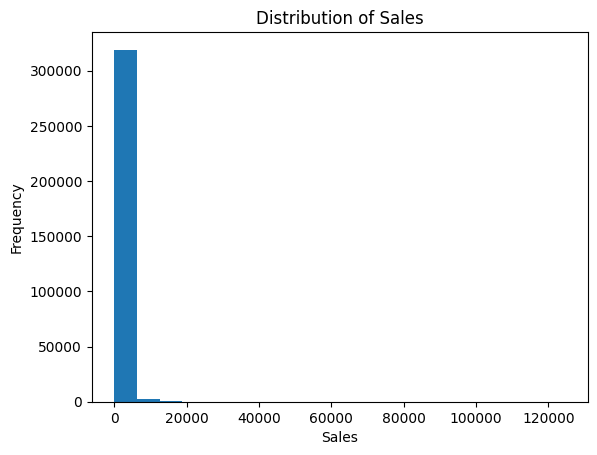

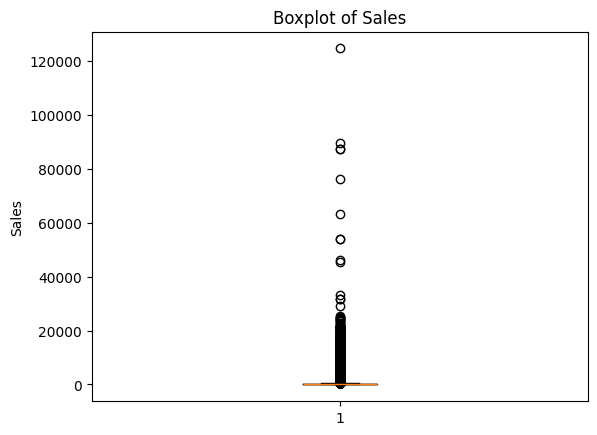

In [4]:
# Histogram
plt.hist(merged_eda_df['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(merged_eda_df['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()


The Sales histogram shows the data spread is from about 0 to 20,000 while the peak occurs in a range of 0 to 10,000. Skewness indicates that the data may not be normally distributed in this case, a right skewed distribution. The box plot further indicates that sales contains extremes, that is, outliers as indicated by the points beyond the whiskers.

##### Transactions Distribution

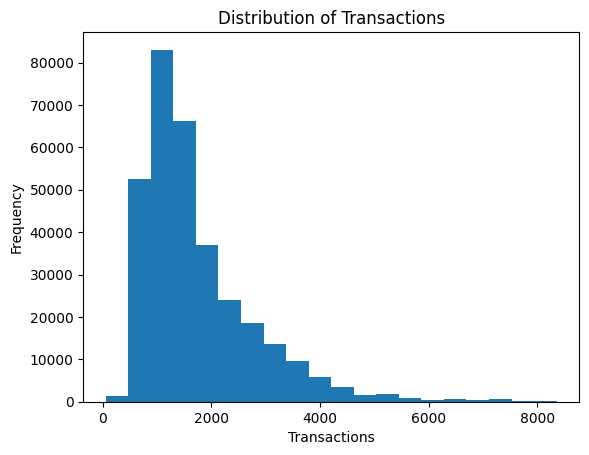

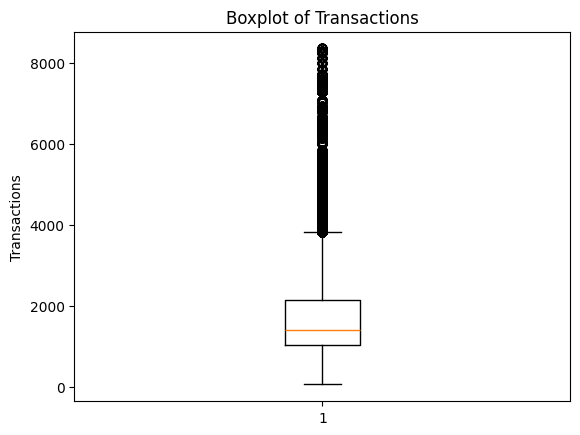

In [5]:

# Histogram
plt.hist(merged_eda_df['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show()

# Boxplot
plt.boxplot(merged_eda_df['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.show()

The transactions histogram shows the data spread is from about 0 to 8,000 transactions while the peak occurs from a range of 500 to 1500 which decreases from there on. The data is left skewed as most of the transactions fall under a specific range. It also seemsthat as the transactions increases, the frequency gradually decreases making it inversely propotional. The box plot further indicates outliers as indicated by the points beyond the whiskers.

##### Oil Distribution

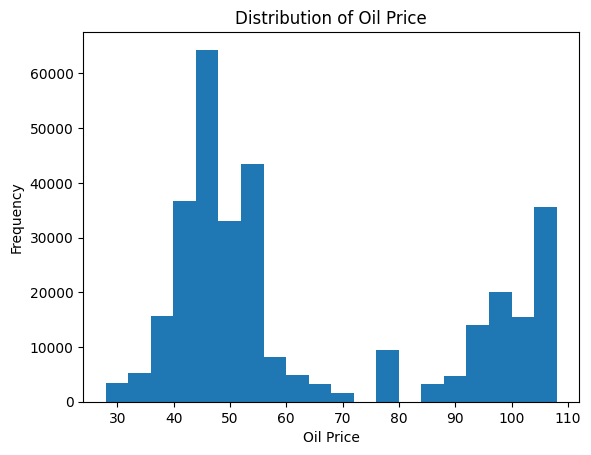

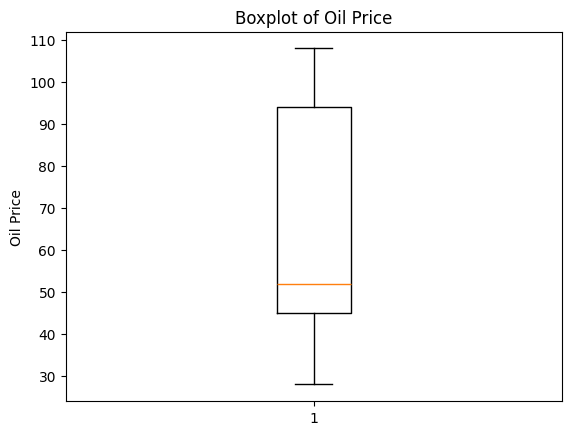

In [6]:
# Histogram
plt.hist(merged_eda_df['dcoilwtico'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

# Boxplot
plt.boxplot(merged_eda_df['dcoilwtico'])
plt.ylabel('Oil Price')
plt.title('Boxplot of Oil Price')
plt.show()

The distribution of oil shows multi-modal data have more than one peak indicating high frequencies at different points.

#### Bivariate Analysis

##### Sales Overtime

In [7]:
# Group the data by date and calculate the total sales
daily_sales = merged_eda_df.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

At this point, it would be difficult to dig into specific factors as many could be directly or indirectly influencing the sales behavious as there are both high and low peaks at various istances.

##### Oil Price Over Time

In [ ]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.

fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

In [ ]:
# Lets plot the trend of oil Prices over time using a lineplot

plt.figure(figsize=(12,6))

sns.lineplot(x='date', y='oil_price', data = merged_eda_df)
plt.title("Trend of Oil Price Over Time", fontsize=(16) )
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.show()

This is the same case with the oil trend as it seems to have started off on a high but then gradually decreased at around 2015, maintaining this range till the end of 2017. Again a couple of factors may be at play given the fluctuations

##### Count Of Sales By Store Type

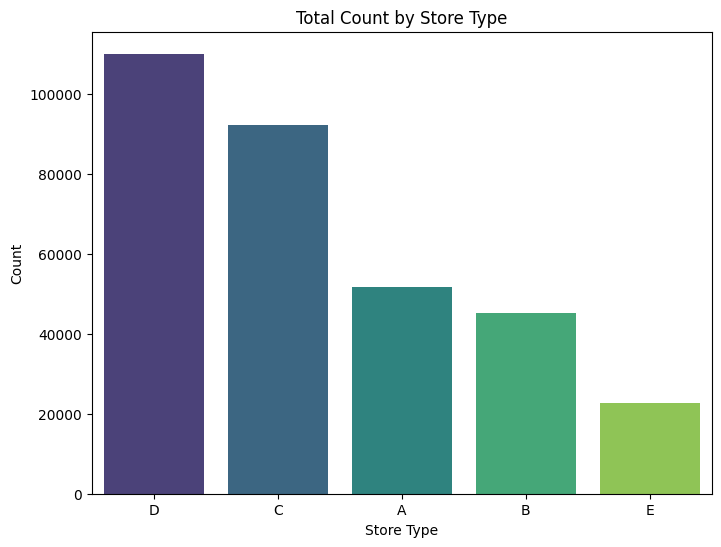

In [8]:
# Calculate the total count and total sales per store type
store_type_counts = merged_eda_df['store_type'].value_counts()
store_type_sales = merged_eda_df.groupby('store_type')['sales'].sum()

# Create a bar plot with "viridis" color palette for total count
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values, palette="viridis")
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Type')
plt.show()

Sales by store type shows a significance in the store type with store D taking the lead with over 100,000 counts followedby store C coming close by a little over 80,000 counts. This could be due to various reasons such as customer loyalty, shopping experience, popularity among other factors. On the other hand, store type A, B and E seem to be having quite a low moderate performance which again, could be attrbuted to other reasons.

##### Amount Of Sales By Store Type

In [ ]:
# Order the store types by total sales
store_type_sales = store_type_sales.sort_values(ascending=False)

# Create a bar plot with "viridis" color palette for total sales
plt.figure(figsize=(8, 8))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, order=store_type_sales.index, palette="viridis")
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Type')
plt.show()

When it comes to the overall sales, store type D takes the lead followed closely by store type A thereby having a significant impacton revenue in total. Store type C comes in followed by store type B and E with low sales volume. This indicates an area for improvement with the three stores as this would drag down the overall revenue.

#### Multivariate Analysis

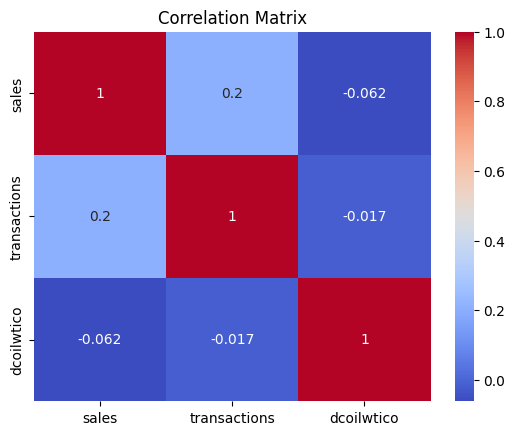

In [9]:
# Select numerical variables for correlation analysis
numerical_variables = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_eda_df[numerical_variables].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- A correlation matrix is a square matrix showing the correlation coefficients between two variables. It is a table of correlation coefficients for a set of variables used to determine if a relationship exists between the variables. 
- The coefficient indicates both the strength of the relationship as well as the direction.  
- Correlation values range from -1 to 1, where -1 signifies a perfect negative correlation, 1 signifies a perfect positive correlation, and 0 indicates no correlation. This matrix illustrates the relationships between variables, offering insights into their interactions:

Sales and Transactions:
A weak positive correlation of about 0.200 is observed between "Sales" and "Transactions," suggesting a slight positive relationship. As the number of transactions increases, sales tend to increase slightly as well, though the correlation is not strong.

Sales and Dcoilwito (Oil Prices):
A weak negative correlation of approximately -0.062 is noted between "Sales" and "Dcoilwito" (Oil Prices). This indicates a minor negative relationship, where higher oil prices are slightly associated with a decrease in sales, but the correlation is not significant.

Transactions and Dcoilwito (Oil Prices):
A very weak negative correlation of around -0.017 is seen between "Transactions" and "Dcoilwito" (Oil Prices). This suggests almost no relationship between the number of transactions and oil prices, indicating that fluctuations in oil prices have minimal impact on transaction numbers.

Overall, the low correlation values reflect weak relationships between these variables. Other factors not included in this matrix might also influence sales, transactions, and oil prices. Further investigation into additional variables is necessary for a more comprehensive understanding of their impacts.

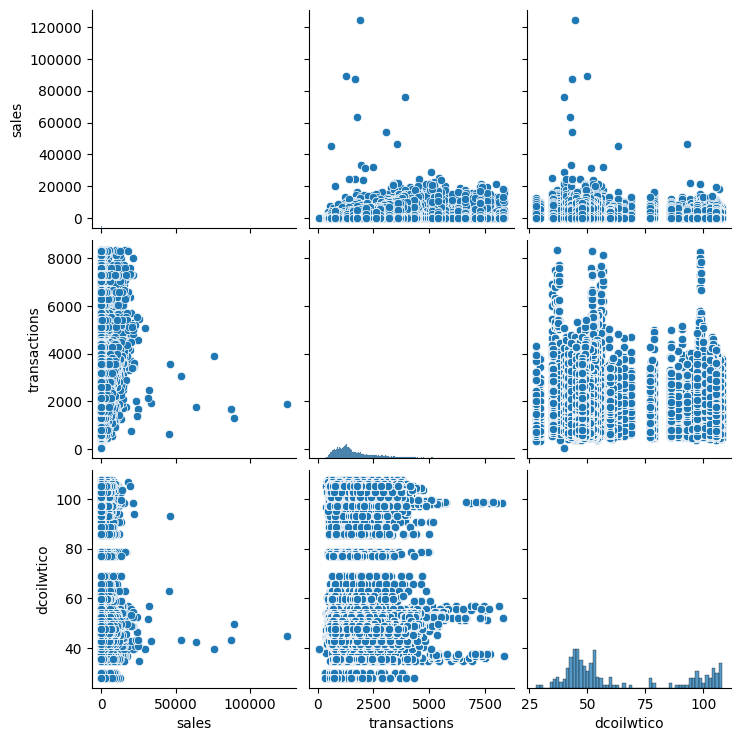

In [10]:
# Select numerical variables for correlation analysis
numerical_variables = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
sns.pairplot(merged_eda_df[numerical_variables])
plt.show()

The scatter plot matrix observations confirm the findings from the correlation matrix.

In [ ]:
# Define the columns to include in the correlation analysis

multivariate_columns = ['sales', 'transactions', 'cluster', 'onpromotion',"oil_price"]
# Calculate the correlation matrix
corr = merged_eda_df[multivariate_columns].corr()

# Plot a heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(data=corr, annot=True, cmap='Greens', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Analytical Questions

#### 1. Is the train dataset complete (has all the required dates)?

In [31]:

# Ensure the date column is in datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Generate a full date range
full_range = pd.date_range(start=train_df['date'].min(), end=train_df['date'].max())

# Find the missing dates
missing_dates = full_range.difference(train_df['date'])

print("Missing Dates:")
print(missing_dates)


'\n# Ensure the date column is in datetime format\ntrain_df[\'date\'] = pd.to_datetime(train_df[\'date\'])\n\n# Generate a full date range\nfull_range = pd.date_range(start=train_df[\'date\'].min(), end=train_df[\'date\'].max())\n\n# Find the missing dates\nmissing_dates = full_range.difference(train_df[\'date\'])\n\nprint("Missing Dates:")\nprint(missing_dates)\n'

In [ ]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_df = pd.concat([train_df, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_df.sort_values('date', inplace=True)

In [ ]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

#### 2. Which dates have the lowest and highest sales for each year?

In [11]:
# Ensure the date column is in datetime format
merged_eda_df['date'] = pd.to_datetime(merged_eda_df['date'])

# Extract year from date
merged_eda_df['year'] = merged_eda_df['date'].dt.year

# Find dates with the highest sales for each year
lowest_sales_dates = merged_eda_df.groupby('year')['date'].min()
highest_sales_dates = merged_eda_df.groupby('year')['date'].max()

print("Dates with the lowest sales for each year:\n", lowest_sales_dates)
print("="*50)
print("Dates with the highest sales for each year:\n", highest_sales_dates)

Dates with the lowest sales for each year:
 year
2013   2013-01-01
2014   2014-01-01
2015   2015-01-01
2016   2016-02-08
2017   2017-01-02
Name: date, dtype: datetime64[ns]
Dates with the highest sales for each year:
 year
2013   2013-12-31
2014   2014-12-31
2015   2015-12-31
2016   2016-12-26
2017   2017-08-15
Name: date, dtype: datetime64[ns]


#### 3. Analyze the impact of the earthquake on sales

In [32]:

# Date the earthquake took place (April 16, 2016)

earthquake_date = pd.to_datetime('2016-04-16')

# Filter the data for the period before and after the earthquake
sales_before_earthquake = train_df[train_df['date'] < earthquake_date]['sales']
sales_after_earthquake = train_df[train_df['date'] > earthquake_date]['sales']

# Calculate total sales before and after the earthquake
total_sales_before = sales_before_earthquake.sum()
total_sales_after = sales_after_earthquake.sum()

print(f"Total sales one month before the earthquake: {total_sales_before}")
print(f"Total sales one month after the earthquake: {total_sales_after}")


'\n# Date the earthquake took place (April 16, 2016)\n\nearthquake_date = pd.to_datetime(\'2016-04-16\')\n\n# Filter the data for the period before and after the earthquake\nsales_before_earthquake = train_df[train_df[\'date\'] < earthquake_date][\'sales\']\nsales_after_earthquake = train_df[train_df[\'date\'] > earthquake_date][\'sales\']\n\n# Calculate total sales before and after the earthquake\ntotal_sales_before = sales_before_earthquake.sum()\ntotal_sales_after = sales_after_earthquake.sum()\n\nprint(f"Total sales one month before the earthquake: {total_sales_before}")\nprint(f"Total sales one month after the earthquake: {total_sales_after}")\n'

In [ ]:
# Set the colormap to viridis
colormap = cm.get_cmap('viridis')

# Plot the sales before and after the earthquake
plt.plot(sales_before_earthquake, color=colormap(0.2), label='Sales Before Earthquake')
plt.plot(sales_after_earthquake, color=colormap(0.8), label='Sales After Earthquake')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

#### 4. Determine if certain groups of stores sell more products

###### Average Sales By Store Type

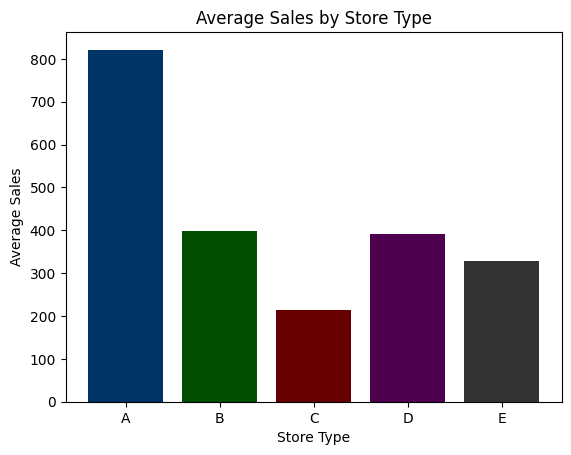

In [12]:
# Group by store type and calculate the average sales

average_sales_by_store_type = merged_eda_df.groupby('store_type')['sales'].mean()

# Plot the average sales by store type
colors = ['#003366', '#004d00', '#660000', '#4d004d', '#333333']
plt.bar(average_sales_by_store_type.index, average_sales_by_store_type.values, color=colors)
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type')
plt.show()

###### Average Sales By State

In [ ]:
# Group by state and calculate the average sales
average_sales_by_state = merged_eda_df.groupby('state')['sales'].mean()

# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

Pichincha has the highest number of stores, primarily due to the presence of Quito, the capital city. Guayas is the second most populous state in terms of stores, with Guayaquil being a major city. Santo Domingo de los Tsachilas, Azuay, Manabi, Cotopaxi, Tungurahua, Los Rios, El Oro, Chimborazo, Imbabura, Bolivar, Pastaza, Santa Elena, and Loja have a moderate number of stores.

###### Average Sales By City

In [ ]:
# Group by city and calculate the average sales
average_sales_by_city = merged_eda_df.groupby('city')['sales'].mean()

# Sort the data by average sales in ascending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Define colors for the bar plot using 'viridis' color palette
colors = cm.viridis(np.linspace(0, 1, len(average_sales_by_city)))

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

Quito has the highest number of stores. Cayambe is the second most populated city in terms of stores followed by Ambato, Daule and Loja. Some cities have a moderate number of stores while others have a lower number of stores. Puyo has the lowest number of sales.

###### Average Sales By Cluster

In [ ]:
# Group by cluster and calculate the average sales
average_sales_by_cluster = merged_df.groupby('cluster')['sales'].mean()

# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Group by state and calculate the average sales
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Group by store type and calculate the average sales
average_sales_by_store_type = merged_df.groupby('store_type')['sales'].mean()

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))

In [ ]:
# Sort the data by average sales in descending order
average_sales_by_cluster = average_sales_by_cluster.sort_values(ascending=False)

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index) + 1))
plt.show()

#### 5. Are sales affected by promotions, oil prices and holidays?

In [13]:
# Calculate correlations between sales and promotions, oil prices, holidays

corr_sales_promotions = merged_eda_df['sales'].corr(merged_eda_df['onpromotion'])
corr_sales_oil = merged_eda_df['sales'].corr(merged_eda_df['dcoilwtico'])
corr_sales_holidays = merged_eda_df['sales'].corr(merged_eda_df['holiday_type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Correlation between Sales and Promotions: 0.4180289197242383
Correlation between Sales and Oil Prices: -0.061509152610695554
Correlation between Sales and Holidays: -0.03706892930251701


In [ ]:
# Prepare data for plotting
labels = ['Sales vs Promotions', 'Sales vs Oil Prices', 'Sales vs Holidays']
correlations = [corr_sales_promotions, corr_sales_oil, corr_sales_holidays]

# Create a DataFrame to sort the correlations
correlation_df = pd.DataFrame({'Feature Pair': labels, 'Correlation': correlations})
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Plot the correlations
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced figure size
bars = sns.barplot(data=correlation_df, x='Correlation', y='Feature Pair', palette='viridis', orient='h', ax=ax)

# Add value annotations
for p in bars.patches:
    bars.annotate(f'{p.get_width():.2f}', (p.get_width() + 0.02, p.get_y() + p.get_height()/2),
                  ha='left', va='center', fontsize=10, color='black')

# Add titles and labels
plt.title('Correlation between Sales and Various Factors', fontsize=14)
plt.xlabel('Correlation', fontsize=12)
plt.ylabel('Feature Pair', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

Sales and Promotions: 0.418

- This positive correlation suggests a moderate relationship between sales and promotions. As promotions increase, sales tend to increase as well. A correlation of 0.418 indicates that promotions have a noticeable, but not overwhelmingly strong, impact on sales.
Sales and Oil Prices: -0.062

Sales and Oil Prices: 0.062
- This near-zero negative correlation implies a very weak inverse relationship between sales and oil prices. Oil prices have minimal impact on sales, with little to no meaningful correlation.
Sales and Holidays: -0.037

Sales and Holidays: 0.037
Interpretation: This correlation is very close to zero and slightly negative, indicating an almost negligible relationship between sales and holidays. The presence of holidays has very little effect on sales based on this correlation.

#### 6. What analysis can we get from the date and its extractable features?

In [14]:
# Extract features from the date

merged_eda_df['year'] = merged_eda_df['date'].dt.year
merged_eda_df['month'] = merged_eda_df['date'].dt.month
merged_eda_df['day'] = merged_eda_df['date'].dt.day
merged_eda_df['day_of_week'] = merged_eda_df['date'].dt.day_name()
merged_eda_df['quarter'] = merged_eda_df['date'].dt.quarter
merged_eda_df['week_of_year'] = merged_eda_df['date'].dt.isocalendar().week
merged_eda_df['is_weekend'] = merged_eda_df['date'].dt.dayofweek >= 5

##### Quarterly Trend

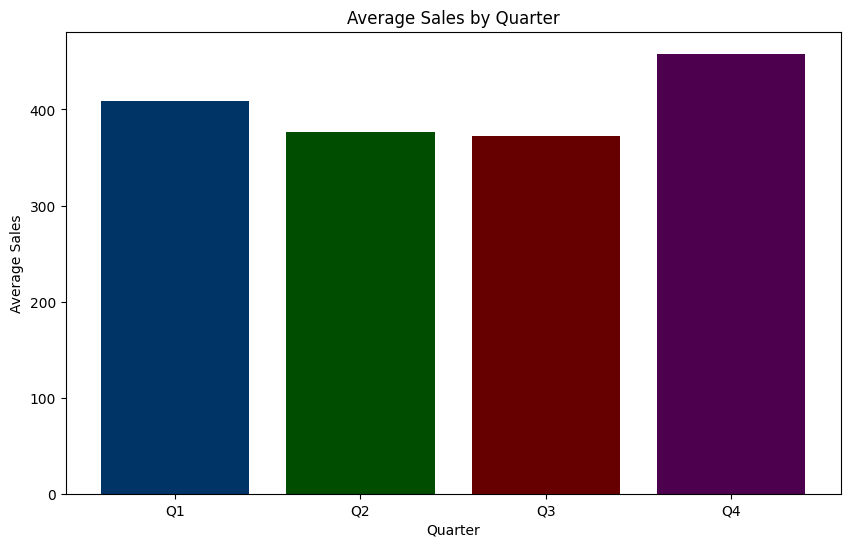

In [15]:
# Average sales by quarter
average_sales_by_quarter = merged_eda_df.groupby('quarter')['sales'].mean()

sns.set_palette('viridis')
colors = ['#003366', '#004d00', '#660000', '#4d004d', '#333333']
plt.figure(figsize=(10, 6))
plt.bar(average_sales_by_quarter.index, average_sales_by_quarter.values, color = colors)
plt.xlabel('Quarter')
plt.ylabel('Average Sales')
plt.title('Average Sales by Quarter')
plt.xticks(ticks=range(1, 5), labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.show()


##### Yearly Trend

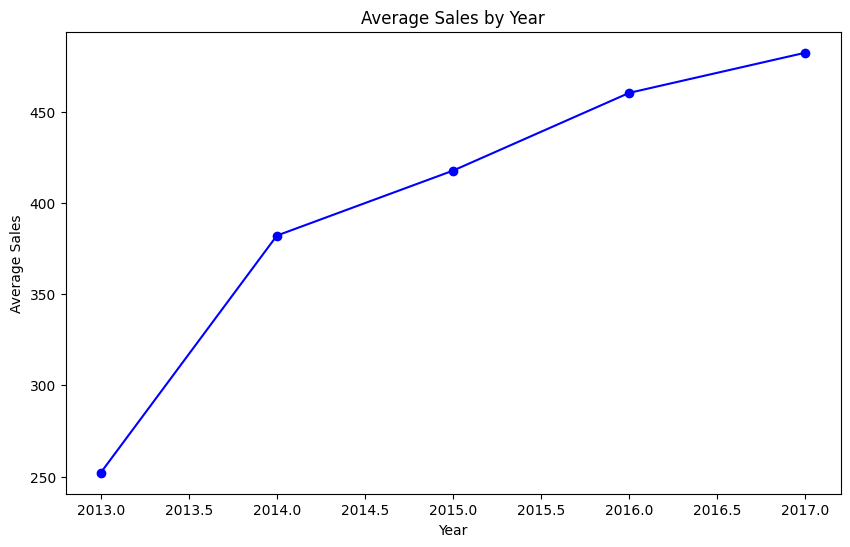

In [16]:
# Average sales by year
average_sales_by_year = merged_eda_df.groupby('year')['sales'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_sales_by_year.index, average_sales_by_year.values, marker='o', color='blue')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales by Year')
plt.grid(False)
plt.show()


##### Monthly Trend

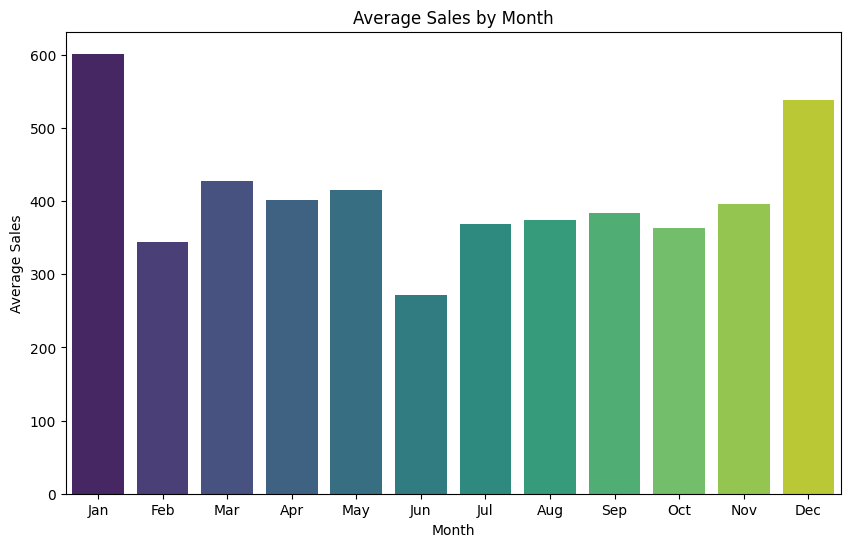

In [17]:

# Average sales by month
average_sales_by_month = merged_eda_df.groupby('month')['sales'].mean()


# Calculating average sales by month
average_sales_by_month = merged_eda_df.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
# Using seaborn barplot
sns.barplot(x='month', y='sales', data=average_sales_by_month, palette='viridis')

# Customizing the plot
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Sales by Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


In [ ]:
# Set distinct colors for each year
colors = sns.color_palette("husl", n_colors=len(merged_eda_df['year'].unique()))

# Visualize the Monthly Sales Trend
monthly_sales = merged_eda_df.groupby(['year', 'month'])['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette=colors)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

The onset of the year seem to have the highest sales, that is, beginning of the year January and towards the end of the year December. The rest of the months seem to perform faily the same but with a slight dip during the month of June then picks up to perform moderately from there on.

##### Weekly Trend

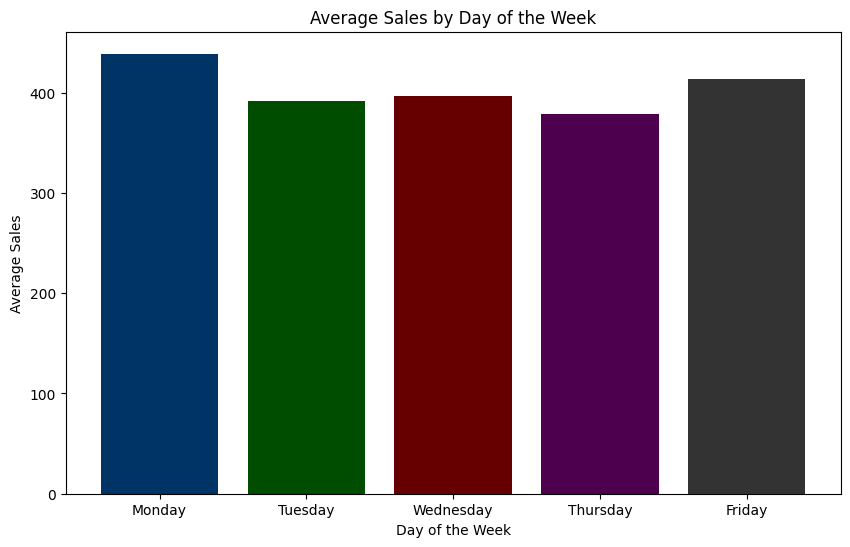

In [18]:
# Average sales by day of the week
average_sales_by_day_of_week = merged_eda_df.groupby('day_of_week')['sales'].mean()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

colors = ['#003366', '#004d00', '#660000', '#4d004d', '#333333']

plt.figure(figsize=(10, 6))
plt.bar(ordered_days, average_sales_by_day_of_week.reindex(ordered_days), color = colors)
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.title('Average Sales by Day of the Week')
plt.show()


Similarly to the year, the days of the week seem to be also performing in the same manner with the highest sales being in the beginning and end of the week. There also seems to be a sliht pick during the mid week particularly on Wednesday.

##### Weekend/Weekday Trend

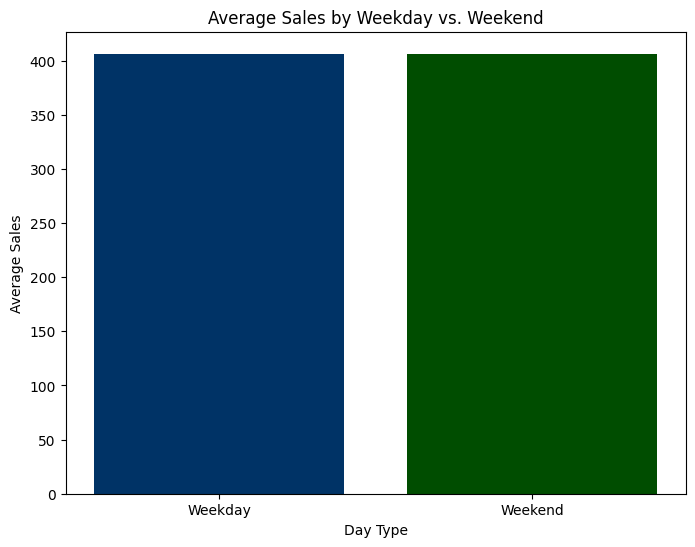

In [19]:
# Average sales by weekend/weekday
average_sales_by_weekend = merged_eda_df.groupby('is_weekend')['sales'].mean()

colors = ['#003366', '#004d00', '#660000', '#4d004d', '#333333']
plt.figure(figsize=(8, 6))
plt.bar(['Weekday', 'Weekend'], average_sales_by_weekend, color = colors)
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Weekday vs. Weekend')
plt.show()


There seems to be a slight to no difference when it comes to the average weekday sales and the average weekend sales

#### 7. Are there certain product families types that exhibit higher sales performance?

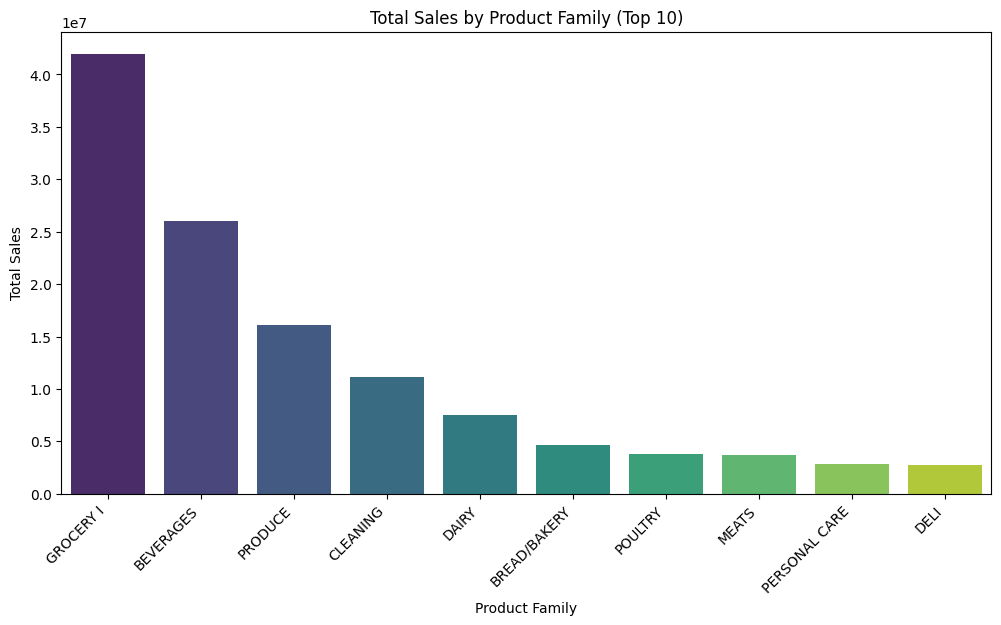

In [20]:
# Group the data by product family and sales
family_sales = merged_eda_df.groupby('family')['sales'].sum().sort_values(ascending=False)

# Select the top 10 product families
top_10_families = family_sales.head(10)

# Plot the family groups
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_families.index, y=top_10_families.values, palette='viridis')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product Family (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.show()

Groceries take the lead when it comes to total sales by product family followed by bevarages and produce. From the results we can conclude that any product family that has anything to do with food is doing well on average in comparison to non - food products.

#### 8. How does the sales trend vary across different store numbers?

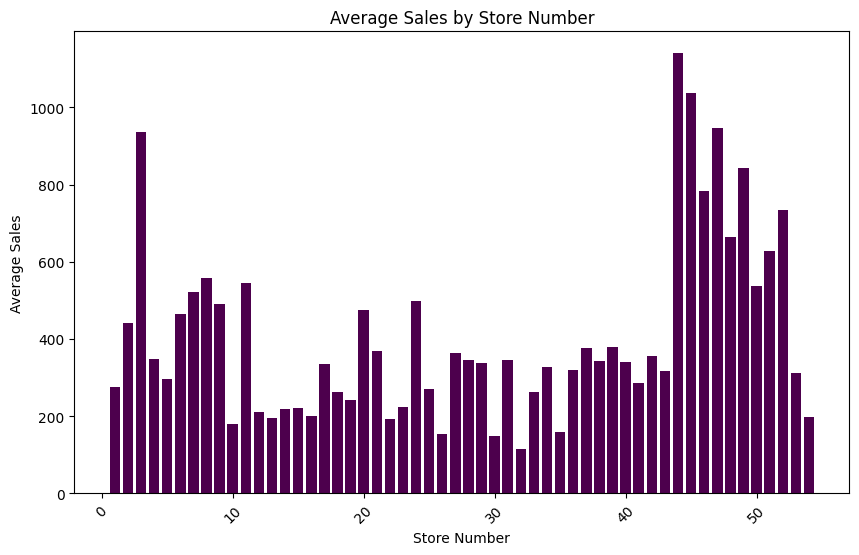

In [21]:
# Calculate average sales per store

average_sales_by_store = merged_eda_df.groupby('store_nbr')['sales'].mean()

plt.figure(figsize=(10, 6))

# Plot average sales per store
plt.bar(average_sales_by_store.index, average_sales_by_store.values, color = '#4d004d')
plt.xlabel('Store Number')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Number')
plt.xticks(rotation=45)
plt.show()

#### Q8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

- RMSE (Root Mean Squared Error): Measures the square root of the average of the squared differences between predicted and actual values. It penalizes larger errors more than smaller ones because the errors are squared.

- MSE (Mean Squared Error): Measures the average of the squared differences between predicted and actual values. Like RMSE, it penalizes larger errors more heavily.

- MAE (Mean Absolute Error): Measures the average of the absolute differences between predicted and actual values. It is less sensitive to outliers compared to RMSE and MSE.

Why MAE Is Greater Than All
- MAE provides a linear penalty for errors, while MSE and RMSE square the errors, which makes them more sensitive to larger errors.
- If the errors are small and relatively consistent, MAE can be greater than RMSE or MSE because the latter metrics are more affected by large deviations.
- MAE does not exaggerate larger errors, so if there are a few large errors, MSE and RMSE might be smaller due to their penalization, whereas MAE remains steady.

- MAE gives a straightforward measure of average error sizewhile MSE and RMSE provide a more severe penalty for larger errors.


#### Q9.  Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales

In [ ]:
# Create a new column to identify if the date is the 15th or the last day of the month
merged_eda_df['day'] = merged_eda_df['date'].dt.day
merged_eda_df['last_day_of_month'] = merged_eda_df['date'] + pd.offsets.MonthEnd(0)
merged_eda_df['is_wage_day'] = merged_eda_df.apply(lambda row: 1 if row['day'] == 15 or row['date'] == row['last_day_of_month'] else 0, axis=1)

# Calculate correlation matrix
correlation_matrix = merged_eda_df[['sales', 'is_wage_day']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Between Sales and Wage Days', fontsize=16)
plt.show()

# Print the correlation value
correlation = correlation_matrix.loc['sales', 'is_wage_day']
print(f"Correlation between Sales and Wage Days: {correlation:.2f}")


Different stores seem to be performing differently and sales seem to be different with accordance to the store numbers

### Hypothesis Testing

In [23]:
# Extract the relevant variables for the hypothesis test
promo_sales = merged_eda_df[merged_eda_df['onpromotion'] == 1]['sales']
non_promo_sales = merged_eda_df[merged_eda_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Extract the relevant variables for the hypothesis test
promo_sales = merged_eda_df[merged_eda_df['onpromotion'] == 1]['sales']
non_promo_sales = merged_eda_df[merged_eda_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.")
print("Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. Promotional activities do not have a significant impact on store sales at Corporation Favorita.")


Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.
Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.
--------------------------------------------------
Test Statistic: 68.21684266478506
P-value: 0.0
Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.


### Stationarity Test

In [4]:

# Statistical Test of the 'sales' column in the merged_eda_df using Adfuller
sales_data = merged_eda_df['sales']

# Perform ADF test
result = adfuller(sales_data)

# Extract the test statistics and p-value from the result
test_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the test statistics and critical values
print(f"ADF Test Statistics: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is non-stationary.")


ADF Test Statistics: -36.021872310135365
P-value: 0.0
Critical Values:
   1%: -3.4303703113224735
   5%: -2.861548977354518
   10%: -2.566774778319785
Reject the null hypothesis: The sales data is stationary.


# Data Pre-Processing

In [24]:
merged_model_df = merged_eda_df.copy()

Getting An Overview Of The Data Before Modelling

In [25]:
merged_model_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,description,transferred,dcoilwtico,year,month,day,day_of_week,quarter,week_of_year,is_weekend
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False


In [26]:
merged_model_df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
year            0
month           0
day             0
day_of_week     0
quarter         0
week_of_year    0
is_weekend      0
dtype: int64

In [28]:
merged_model_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'transactions', 'holiday_type',
       'locale', 'locale_name', 'description', 'transferred', 'dcoilwtico',
       'year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year',
       'is_weekend'],
      dtype='object')

## Feature Engineering

### Product Categorization

In [29]:
merged_model_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [30]:
# Category lists for each product category
food_bevarages = ['BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'LIQUOR, WINE, BEER', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']
household_items = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'CLEANING']
clothing_accessories = ['LINGERIE', 'LADYSWARE']
grocery_products = ['GROCERY I', 'GROCERY II']
stationery_supplies = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
beauty_care = ['BEAUTY', 'BABY CARE','PERSONAL CARE']
electronics_hardware = ['PLAYERS AND ELECTRONICS','HARDWARE']
pets_outdoor = ['LAWN AND GARDEN', 'PET SUPPLIES']
automotive = ['AUTOMOTIVE']

def categorize_family(family):
    if family in food_bevarages:
        return 'FOOD & BEVARAGES'
    elif family in household_items:
        return 'HOUSEHOLD ITEMS'
    elif family in clothing_accessories:
        return 'CLOTHING ACCESSORIES'
    elif family in grocery_products:
        return 'GROCERY'
    elif family in stationery_supplies:
        return 'STATIONERY SUPPLIES'
    elif family in beauty_care:
        return 'PERSONAL & BEAUTY CARE'
    elif family in electronics_hardware:
        return 'HARDWARE & ELECTRONICS'
    elif family in pets_outdoor:
        return 'PETS & OUTDOORS'
    elif family in automotive:
        return 'AUTOMOTIVE'
    else:
        return family

# Apply the custom function to the 'family' column
merged_model_df['family'] = merged_model_df['family'].apply(categorize_family)


merged_model_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,description,transferred,dcoilwtico,year,month,day,day_of_week,quarter,week_of_year,is_weekend
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
1,562,2013-01-01,25,PERSONAL & BEAUTY CARE,0.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
2,563,2013-01-01,25,PERSONAL & BEAUTY CARE,2.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
3,564,2013-01-01,25,FOOD & BEVARAGES,810.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False
4,565,2013-01-01,25,STATIONERY SUPPLIES,0.0,0,Salinas,Santa Elena,D,1,...,Primer dia del ano,False,93.139999,2013,1,1,Tuesday,1,1,False


In [31]:
merged_model_df['family'].unique()

array(['AUTOMOTIVE', 'PERSONAL & BEAUTY CARE', 'FOOD & BEVARAGES',
       'STATIONERY SUPPLIES', 'CELEBRATION', 'HOUSEHOLD ITEMS',
       'HARDWARE & ELECTRONICS', 'LADIESWEAR', 'PETS & OUTDOORS',
       'CLOTHING ACCESSORIES', 'LIQUOR,WINE,BEER'], dtype=object)

Drop Unnecesary Columns

In [32]:
merged_model_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'transactions', 'holiday_type',
       'locale', 'locale_name', 'description', 'transferred', 'dcoilwtico',
       'year', 'month', 'day', 'day_of_week', 'quarter', 'week_of_year',
       'is_weekend'],
      dtype='object')

In [ ]:
columns_to_drop = ['date','id', 'locale_name', 'description', 'transferred', 'state', 'city', 'is_weekend', 'week_of_year', 'day']

merged_model_df = merged_model_df.drop(columns=columns_to_drop)

merged_model_df.head()

In [35]:
merged_model_df.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'store_type', 'cluster',
       'transactions', 'holiday_type', 'locale', 'dcoilwtico', 'year', 'month',
       'day_of_week', 'quarter'],
      dtype='object')

Defining Numerical and Categorical Columns

In [36]:
merged_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_nbr     322047 non-null  int64  
 1   family        322047 non-null  object 
 2   sales         322047 non-null  float64
 3   onpromotion   322047 non-null  int64  
 4   store_type    322047 non-null  object 
 5   cluster       322047 non-null  int64  
 6   transactions  322047 non-null  int64  
 7   holiday_type  322047 non-null  object 
 8   locale        322047 non-null  object 
 9   dcoilwtico    322047 non-null  float64
 10  year          322047 non-null  int32  
 11  month         322047 non-null  int32  
 12  day_of_week   322047 non-null  object 
 13  quarter       322047 non-null  int32  
dtypes: float64(2), int32(3), int64(4), object(5)
memory usage: 30.7+ MB


### Feature Scaling

In [37]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = RobustScaler()

# select numerical columns
numerical_columns = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_model_df[numerical_columns] = scaler.fit_transform(merged_model_df[numerical_columns])

# Display the updated dataframe
merged_model_df.head()

,store_nbr,family,sales,onpromotion,store_type,cluster,transactions,holiday_type,locale,dcoilwtico,year,month,day_of_week,quarter
0,25,AUTOMOTIVE,-0.079081,0,D,1,-0.571556,Holiday,National,0.836415,2013,1,Tuesday,1
1,25,PERSONAL & BEAUTY CARE,-0.079081,0,D,1,-0.571556,Holiday,National,0.836415,2013,1,Tuesday,1
2,25,PERSONAL & BEAUTY CARE,-0.070757,0,D,1,-0.571556,Holiday,National,0.836415,2013,1,Tuesday,1
3,25,FOOD & BEVARAGES,3.292260,0,D,1,-0.571556,Holiday,National,0.836415,2013,1,Tuesday,1
4,25,STATIONERY SUPPLIES,-0.079081,0,D,1,-0.571556,Holiday,National,0.836415,2013,1,Tuesday,1


### Encoding Categorical Data

In [38]:
# Define the categorical columns to encode
categorical_columns = ['family', 'holiday_type', 'locale', 'day_of_week', 'store_type']

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_model_df[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_model_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_model_encoded = pd.concat([merged_model_df, merged_model_encoded], axis=1)

# Drop the original categorical columns
merged_model_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_model_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,quarter,family_AUTOMOTIVE,...,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E
0,25,-0.079081,0,1,-0.571556,0.836415,2013,1,1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25,-0.079081,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,-0.070757,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,25,3.292260,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25,-0.079081,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Test Dataset

In [39]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [40]:
# Extracting Date Components

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df.head()

,id,date,store_nbr,family,onpromotion,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16


In [41]:
# Dropping Unnecessary Columns

columns_to_drop = ['date', 'id']
test_df = test_df.drop(columns=columns_to_drop)
test_df.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,BABY CARE,0,2017,8,16
2,1,BEAUTY,2,2017,8,16
3,1,BEVERAGES,20,2017,8,16
4,1,BOOKS,0,2017,8,16


In [42]:
# Category lists for each product category

food_bevarages = ['BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'LIQUOR, WINE, BEER', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']
household_items = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'CLEANING']
clothing_accessories = ['LINGERIE', 'LADYSWARE']
grocery_products = ['GROCERY I', 'GROCERY II']
stationery_supplies = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
beauty_care = ['BEAUTY', 'BABY CARE','PERSONAL CARE']
electronics_hardware = ['PLAYERS AND ELECTRONICS','HARDWARE']
pets_outdoor = ['LAWN AND GARDEN', 'PET SUPPLIES']
automotive = ['AUTOMOTIVE']

def categorize_family(family):
    if family in food_bevarages:
        return 'FOOD & BEVARAGES'
    elif family in household_items:
        return 'HOUSEHOLD ITEMS'
    elif family in clothing_accessories:
        return 'CLOTHING ACCESSORIES'
    elif family in grocery_products:
        return 'GROCERY'
    elif family in stationery_supplies:
        return 'STATIONERY SUPPLIES'
    elif family in beauty_care:
        return 'PERSONAL & BEAUTY CARE'
    elif family in electronics_hardware:
        return 'HARDWARE & ELECTRONICS'
    elif family in pets_outdoor:
        return 'PETS & OUTDOORS'
    elif family in automotive:
        return 'AUTOMOTIVE'
    else:
        return family

# Apply the custom function to the 'family' column
test_df['family'] = test_df['family'].apply(categorize_family)


test_df.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,PERSONAL & BEAUTY CARE,0,2017,8,16
2,1,PERSONAL & BEAUTY CARE,2,2017,8,16
3,1,FOOD & BEVARAGES,20,2017,8,16
4,1,STATIONERY SUPPLIES,0,2017,8,16


In [43]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ['family']

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'test_df' data for the specified categorical columns
one_hot_encoded_data = encoder.fit_transform(test_df[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
test_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
test_df_encoded = pd.concat([test_df, test_df_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
test_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
test_df_encoded.head()

,store_nbr,onpromotion,year,month,day,family_AUTOMOTIVE,family_CELEBRATION,family_CLOTHING ACCESSORIES,family_FOOD & BEVARAGES,family_HARDWARE & ELECTRONICS,family_HOUSEHOLD ITEMS,family_LADIESWEAR,"family_LIQUOR,WINE,BEER",family_PERSONAL & BEAUTY CARE,family_PETS & OUTDOORS,family_STATIONERY SUPPLIES
0,1,0,2017,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,2,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,20,2017,8,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modelling

### Data Splitting

In [44]:
train_set = merged_model_encoded.loc[merged_model_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_model_encoded.loc[merged_model_encoded['year'] == 2017]

In [45]:
train_set.shape

(284889, 38)

In [48]:
eval_set.shape

(37158, 38)

In [49]:
train_set.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,quarter,family_AUTOMOTIVE,...,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E
0,25,-0.079081,0,1,-0.571556,0.836415,2013,1,1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25,-0.079081,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,-0.070757,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,25,3.292260,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25,-0.079081,0,1,-0.571556,0.836415,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [50]:
eval_set.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,quarter,family_AUTOMOTIVE,...,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E
284889,1,-0.058270,0,13,-0.798748,0.007722,2017,1,1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
284890,1,-0.079081,0,13,-0.798748,0.007722,2017,1,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
284891,1,-0.079081,0,13,-0.798748,0.007722,2017,1,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
284892,1,5.889441,31,13,-0.798748,0.007722,2017,1,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
284893,1,-0.079081,0,13,-0.798748,0.007722,2017,1,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
# Separate the target variable and features for training and testing

X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

### Linear Regression Model

In [51]:

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
lr_mse = mean_squared_error(y_eval, lr_predictions)
lr_mae = mean_absolute_error(y_eval, lr_predictions)
lr_r2 = r2_score(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae],
                            'R2': [lr_r2]}).round(2)
# Print the results_lr dataframe
results_lr

,Model,RMSLE,RMSE,MSE,MAE,R2
0,Linear Regression,0.69,4.41,19.46,2.01,0.39


Root Mean Squared Logarithmic Error (RMSLE): 0.69
The RMSLE of 0.69 indicates moderate relative errors in the predictions. This value suggests that while the model's predictions are somewhat close to the actual values, the errors are noticeable and significant for some predictions.

Root Mean Squared Error (RMSE): 4.41
An RMSE of 4.41 means that on average, the prediction error is 4.41 units. This value, being relatively high, indicates substantial deviations between the predicted and actual values, suggesting the presence of some significant outliers.

Mean Squared Error (MSE): 19.46
The MSE of 19.46 reflects the average squared prediction errors. This value is quite high, signifying that the prediction errors are large on average, likely influenced by substantial outliers.

Mean Absolute Error (MAE): 2.01
The MAE of 2.01 shows the average magnitude of the errors in the predictions. This value indicates that, on average, the model's predictions deviate from the actual values by 2.01 units, which suggests reasonable prediction accuracy but with noticeable errors.

R² (Coefficient of Determination): 0.39
An R² of 0.39 means that the model explains only 39% of the variance in the actual values. This low value indicates that the model has limited predictive power and does not capture much of the underlying pattern in the data.

Summary
RMSLE (0.69): Indicates moderate relative errors in predictions, suggesting some significant deviations.
RMSE (4.41): Reflects substantial prediction errors on average, suggesting significant deviations between predicted and actual values.
MSE (19.46): Indicates large average squared prediction errors, influenced by significant outliers.
MAE (2.01): Shows the average magnitude of errors, indicating reasonable prediction accuracy but with noticeable deviations.
R² (0.39): Indicates that the model explains only 39% of the variance in the target variable, suggesting limited predictive power.
Overall, the Linear Regression model exhibits moderate performance with noticeable prediction errors and limited explanatory power. The RMSLE, RMSE, and MSE values suggest significant deviations, while the MAE indicates reasonable average prediction accuracy. The low R² value highlights the need for model improvements or alternative modeling approaches to better capture the underlying patterns in the data.

### Gradient Boosting Regressor

In [54]:

# Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_eval)

# Calculate metrics
gb_mse = mean_squared_error(y_eval, gb_predictions)
gb_mae = mean_absolute_error(y_eval, gb_predictions)
gb_r2 = r2_score(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gb_predictions_abs = abs(gb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gb_predictions_abs))

# Create a DataFrame to store results for Gradient Boosting
results_gb = pd.DataFrame({'Model': ['Gradient Boosting'],
                            'RMSLE': [gb_rmsle],
                            'RMSE': [np.sqrt(gb_mse)],
                            'MSE': [gb_mse],
                            'MAE': [lr_mae],
                            'R2': [gb_r2]}).round(2)
# Print the results_gb dataframe
results_gb

,Model,RMSLE,RMSE,MSE,MAE,R2
0,Gradient Boosting,0.55,3.51,12.31,2.01,0.39


Root Mean Squared Logarithmic Error (RMSLE): 0.55
The RMSLE of 0.55 indicates smaller relative errors in the predictions compared to the Linear Regression model's RMSLE of 0.69. This suggests that the Gradient Boosting model's predictions are closer to the actual values in terms of their relative differences, demonstrating better performance.

Root Mean Squared Error (RMSE): 3.51
An RMSE of 3.51, which is lower than the RMSE of the Linear Regression model (4.41), means that on average, the prediction error is smaller. This indicates better accuracy in the predictions made by the Gradient Boosting model.

Mean Squared Error (MSE): 12.31
The MSE of 12.31 is lower than the MSE of the Linear Regression model (19.46). This indicates that the Gradient Boosting model has smaller average squared prediction errors, suggesting an improvement in model accuracy compared to the Linear Regression model.

Mean Absolute Error (MAE): 2.01
The MAE of 2.01 is the same as the MAE of the Linear Regression model. This indicates that the average magnitude of the errors in the predictions is the same for both models. However, other metrics show the Gradient Boosting model's overall better performance.

R² (Coefficient of Determination): 0.39
An R² of 0.39 is the same as that of the Linear Regression model. This means that the Gradient Boosting model explains the same amount of variance in the actual values as the Linear Regression model. While the R² value does not show improvement, other metrics suggest better performance in terms of prediction errors.

Summary
RMSLE (0.55): Lower than the Linear Regression model (0.69), indicating smaller relative errors and better performance.
RMSE (3.51): Lower than the Linear Regression model (4.41), suggesting more accurate predictions on average.
MSE (12.31): Lower than the Linear Regression model (19.46), indicating smaller average squared prediction errors.
MAE (2.01): The same as the Linear Regression model, indicating similar average error magnitudes.
R² (0.39): The same as the Linear Regression model, indicating the same explanatory power in terms of variance.
Overall, the Gradient Boosting model performs better than the Linear Regression model with smaller errors in terms of RMSLE, RMSE, and MSE. The MAE and R² values are the same for both models, suggesting that while the Gradient Boosting model has better prediction accuracy, it explains the same amount of variance in the target variable. The Gradient Boosting model demonstrates improved accuracy and reliability in its predictions.

### Random Forest Regression

In [55]:

# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)
rf_r2 = r2_score(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [lr_mae],
                            'R2': [rf_r2]}).round(2)
# Print the results_rf dataframe
results_rf

,Model,RMSLE,RMSE,MSE,MAE,R2
0,Random Forest,0.52,3.64,13.24,2.01,0.39


Root Mean Squared Logarithmic Error (RMSLE): 0.52
The RMSLE of 0.52 indicates smaller relative errors in the predictions compared to the Linear Regression model's RMSLE of 0.69 and the Gradient Boosting model's RMSLE of 0.55. This suggests that the Random Forest model's predictions are closer to the actual values in terms of their relative differences, demonstrating the best performance among the three models.

Root Mean Squared Error (RMSE): 3.64
An RMSE of 3.64, which is lower than the RMSE of the Linear Regression model (4.41) but slightly higher than the Gradient Boosting model's RMSE (3.51), means that on average, the prediction error is smaller than the Linear Regression model but slightly larger than the Gradient Boosting model. This indicates relatively good accuracy in the predictions made by the Random Forest model.

Mean Squared Error (MSE): 13.24
The MSE of 13.24 is lower than the MSE of the Linear Regression model (19.46) but higher than the Gradient Boosting model's MSE (12.31). This indicates that the Random Forest model has smaller average squared prediction errors compared to the Linear Regression model, suggesting improved accuracy, but it is slightly less accurate than the Gradient Boosting model.

Mean Absolute Error (MAE): 2.01
The MAE of 2.01 is the same as the MAE of the Linear Regression model and the Gradient Boosting model. This indicates that the average magnitude of the errors in the predictions is the same for all three models. However, other metrics show the Random Forest model's overall better performance in some aspects.

R² (Coefficient of Determination): 0.39
An R² of 0.39 is the same as that of the Linear Regression model and the Gradient Boosting model. This means that the Random Forest model explains the same amount of variance in the actual values as the other models. While the R² value does not show improvement, other metrics suggest better performance in terms of prediction errors.

Summary
RMSLE (0.52): Lower than both the Linear Regression model (0.69) and the Gradient Boosting model (0.55), indicating smaller relative errors and the best performance among the three models.
RMSE (3.64): Lower than the Linear Regression model (4.41) but slightly higher than the Gradient Boosting model (3.51), suggesting good accuracy but slightly worse than the Gradient Boosting model.
MSE (13.24): Lower than the Linear Regression model (19.46) but higher than the Gradient Boosting model (12.31), indicating improved accuracy compared to the Linear Regression model but slightly less accurate than the Gradient Boosting model.
MAE (2.01): The same as both the Linear Regression model and the Gradient Boosting model, indicating similar average error magnitudes.
R² (0.39): The same as the Linear Regression model and the Gradient Boosting model, indicating the same explanatory power in terms of variance.
Overall, the Random Forest model demonstrates better performance than the Linear Regression model with smaller errors in terms of RMSLE, RMSE, and MSE. The RMSLE of 0.52 indicates the best performance in terms of relative errors among the three models. The MAE and R² values are the same for all models, suggesting that while the Random Forest model has good prediction accuracy, it explains the same amount of variance in the target variable as the other models. The Random Forest model shows a balance of accuracy and reliability in its predictions, slightly underperforming only to the Gradient Boosting model in some metrics.

## XGBoost Regressor

In [52]:

# Fit the XGBoost Regressor Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_eval)

# Calculate metrics
xgb_mse = mean_squared_error(y_eval, xgb_predictions)
xgb_mae = mean_absolute_error(y_eval, xgb_predictions)
xgb_r2 = r2_score(y_eval, xgb_predictions)

# Apply the absolute value function to both y_eval and xgb_predictions
y_eval_abs = abs(y_eval)
xgb_predictions_abs = abs(xgb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, xgb_predictions_abs))

# Create a DataFrame to store results for XGBoost Regressor
results_xgb = pd.DataFrame({'Model': ['XGBoost Regressor'],
                            'RMSLE': [xgb_rmsle],
                            'RMSE': [np.sqrt(xgb_mse)],
                            'MSE': [xgb_mse],
                            'MAE': [xgb_mae],
                            'R2': [xgb_r2]}).round(2)

# Print the results_xgb dataframe
print(results_xgb)


               Model  RMSLE  RMSE    MSE   MAE    R2
0  XGBoost Regressor   0.54   3.5  12.26  1.54  0.62


Root Mean Squared Logarithmic Error (RMSLE): 0.54
The RMSLE of 0.54 indicates smaller relative errors in the predictions compared to the Linear Regression model (0.69), Gradient Boosting model (0.55), and Random Forest model (0.52). This suggests that the XGBoost Regressor's predictions are closer to the actual values in terms of their relative differences, demonstrating better performance than Gradient Boosting and comparable performance to Random Forest.

Root Mean Squared Error (RMSE): 3.5
An RMSE of 3.5 is lower than the RMSE of the Linear Regression model (4.41), Gradient Boosting model (3.51), and Random Forest model (3.64). This means that, on average, the prediction error is smaller, indicating better accuracy in the predictions made by the XGBoost Regressor.

Mean Squared Error (MSE): 12.26
The MSE of 12.26 is lower than the MSE of the Linear Regression model (19.46), Gradient Boosting model (12.31), and Random Forest model (13.24). This indicates that the XGBoost Regressor has smaller average squared prediction errors, suggesting an improvement in model accuracy compared to the other models.

Mean Absolute Error (MAE): 1.54
The MAE of 1.54 is lower than the MAE of the Linear Regression model (2.01), Gradient Boosting model (2.01), and Random Forest model (2.01). This indicates that the average magnitude of the errors in the predictions is smaller for the XGBoost Regressor, demonstrating more accurate predictions on average.

R² (Coefficient of Determination): 0.62
An R² of 0.62 means that the model explains 62% of the variance in the actual values. This is a significant improvement over the Linear Regression model (0.39), Gradient Boosting model (0.39), and Random Forest model (0.39), indicating that the XGBoost Regressor captures more of the underlying pattern in the data.

Summary
RMSLE (0.54): Lower than Linear Regression (0.69) and Gradient Boosting (0.55), and comparable to Random Forest (0.52), indicating smaller relative errors and strong performance.
RMSE (3.5): Lower than Linear Regression (4.41), Gradient Boosting (3.51), and Random Forest (3.64), suggesting more accurate predictions.
MSE (12.26): Lower than Linear Regression (19.46), Gradient Boosting (12.31), and Random Forest (13.24), indicating smaller average squared prediction errors.
MAE (1.54): Lower than Linear Regression (2.01), Gradient Boosting (2.01), and Random Forest (2.01), indicating smaller average error magnitude.
R² (0.62): Higher than Linear Regression (0.39), Gradient Boosting (0.39), and Random Forest (0.39), indicating better explanatory power and capturing more of the data's variance.
Overall, the XGBoost Regressor model performs better than the Linear Regression, Gradient Boosting, and Random Forest models with smaller errors and higher explanatory power. The RMSLE, RMSE, and MSE values indicate improved accuracy, while the MAE suggests more precise predictions on average. The higher R² value highlights the model's superior ability to capture the variance in the target variable. The XGBoost Regressor demonstrates enhanced accuracy and reliability in its predictions compared to the other models, making it the best performer in this evaluation.

## ARIMA Model

In [53]:

# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_r2 = r2_score(y_eval, arima_predictions)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)


# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae],
                            'R2': [arima_r2]}).round(2)
# Print the results_arima dataframe
results_arima


,Model,RMSLE,RMSE,MSE,MAE,R2
0,ARIMA,0.91,5.65,31.96,2.57,-0.0


Root Mean Squared Logarithmic Error (RMSLE): 0.91
The RMSLE of 0.91 indicates relatively high relative errors in the predictions. This value is higher than the RMSLE of the Linear Regression model (0.69), Gradient Boosting model (0.55), Random Forest model (0.52), and XGBoost Regressor (0.54). This suggests that the ARIMA model's predictions are less accurate relative to the other models, with more significant discrepancies in relative terms.

Root Mean Squared Error (RMSE): 5.65
An RMSE of 5.65 is higher than the RMSE of the Linear Regression model (4.41), Gradient Boosting model (3.51), Random Forest model (3.64), and XGBoost Regressor (3.5). This means that, on average, the prediction error is larger, indicating poorer accuracy in the ARIMA model's predictions compared to the other models.

Mean Squared Error (MSE): 31.96
The MSE of 31.96 is higher than the MSE of the Linear Regression model (19.46), Gradient Boosting model (12.31), Random Forest model (13.24), and XGBoost Regressor (12.26). This indicates that the ARIMA model has larger average squared prediction errors, suggesting significantly worse accuracy compared to the other models.

Mean Absolute Error (MAE): 2.57
The MAE of 2.57 is higher than the MAE of the Linear Regression model (2.01), Gradient Boosting model (2.01), Random Forest model (2.01), and XGBoost Regressor (1.54). This indicates that the average magnitude of the errors in the predictions is larger for the ARIMA model, showing poorer performance in terms of average prediction accuracy.

R² (Coefficient of Determination): -0.0
An R² of -0.0 indicates that the ARIMA model performs worse than a simple mean-based model, explaining virtually none of the variance in the actual values. This is significantly worse compared to the R² values of Linear Regression (0.39), Gradient Boosting (0.39), Random Forest (0.39), and XGBoost Regressor (0.62). A negative R² value suggests that the model is not capturing the underlying patterns in the data effectively and is performing poorly.

Summary
RMSLE (0.91): Higher than Linear Regression (0.69), Gradient Boosting (0.55), Random Forest (0.52), and XGBoost Regressor (0.54), indicating larger relative prediction errors.
RMSE (5.65): Higher than Linear Regression (4.41), Gradient Boosting (3.51), Random Forest (3.64), and XGBoost Regressor (3.5), suggesting poorer prediction accuracy.
MSE (31.96): Higher than Linear Regression (19.46), Gradient Boosting (12.31), Random Forest (13.24), and XGBoost Regressor (12.26), indicating larger average squared prediction errors.
MAE (2.57): Higher than Linear Regression (2.01), Gradient Boosting (2.01), Random Forest (2.01), and XGBoost Regressor (1.54), indicating larger average error magnitude.
R² (-0.0): Significantly lower than Linear Regression (0.39), Gradient Boosting (0.39), Random Forest (0.39), and XGBoost Regressor (0.62), indicating poor explanatory power and a model that does not effectively capture the variance in the data.
Overall, the ARIMA model shows the poorest performance among all the models. It has the highest RMSLE, RMSE, MSE, and MAE, and the lowest R² value, indicating that it is less accurate and less effective at capturing the variance in the target variable compared to Linear Regression, Gradient Boosting, Random Forest, and XGBoost Regressor.

## Hyperparameter Tuning 

## Random Forest

In [67]:
# Define the parameter grid for tuning the random forest model
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                      n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search_rf.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_

# Make predictions using the best model
best_rf_predictions = best_rf_model.predict(X_eval)

# Calculate metrics for the best model
best_rf_mse = mean_squared_error(y_eval, best_rf_predictions)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_mae = mean_absolute_error(y_eval, best_rf_predictions)
best_rf_r2 = r2_score(y_eval, best_rf_predictions)

# Apply absolute value to both predicted and target values
abs_best_rf_predictions = np.abs(best_rf_predictions)
abs_y_eval = np.abs(y_eval)

# Calculate RMSLE using the absolute values
best_rf_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_rf_predictions))

# Create a DataFrame to store results for the best Random Forest model
best_results_rf = pd.DataFrame({'Model': ['Best Random Forest'],
                                'RMSLE': [best_rf_rmsle],
                                'RMSE': [best_rf_rmse],
                                'MSE': [best_rf_mse],
                                'MAE': [best_rf_mae],
                                'R2': [best_rf_r2]}).round(2)

# Print the best_results_rf dataframe
best_results_rf

,Model,RMSLE,RMSE,MSE,MAE,R2
0,Best Random Forest,0.52,3.38,11.39,1.42,0.64


## XGBoost Regressor

In [68]:

# Define the parameter grid for tuning the XGBoost model
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid_xgb,
                                        n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                        n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search_xgb.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_params = random_search_xgb.best_params_

# Make predictions using the best model
best_xgb_predictions = best_xgb_model.predict(X_eval)

# Calculate metrics for the best model
best_xgb_mse = mean_squared_error(y_eval, best_xgb_predictions)
best_xgb_rmse = np.sqrt(best_xgb_mse)
best_xgb_mae = mean_absolute_error(y_eval, best_xgb_predictions)
best_xgb_r2 = r2_score(y_eval, best_xgb_predictions)

# Apply absolute value to both predicted and target values
abs_best_xgb_predictions = np.abs(best_xgb_predictions)
abs_y_eval = np.abs(y_eval)

# Calculate RMSLE using the absolute values
best_xgb_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_xgb_predictions))

# Create a DataFrame to store results for the best XGBoost model
best_results_xgb = pd.DataFrame({'Model': ['Best XGBoost Regressor'],
                                 'RMSLE': [best_xgb_rmsle],
                                 'RMSE': [best_xgb_rmse],
                                 'MSE': [best_xgb_mse],
                                 'MAE': [best_xgb_mae],
                                 'R2': [best_rf_r2]}).round(2)

# Print the best_results_xgb dataframe
print(best_results_xgb)


                    Model  RMSLE  RMSE    MSE  MAE    R2
0  Best XGBoost Regressor   0.54  3.57  12.77  1.6  0.64


## Gradient Boost Regressor

In [69]:
# Define the parameter grid for tuning the Gradient Boosting model
param_grid_gb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_grid_gb,
                                       n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                       n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search_gb.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_gb_model = random_search_gb.best_estimator_
best_gb_params = random_search_gb.best_params_

# Make predictions using the best model
best_gb_predictions = best_gb_model.predict(X_eval)

# Calculate metrics for the best model
best_gb_mse = mean_squared_error(y_eval, best_gb_predictions)
best_gb_rmse = np.sqrt(best_gb_mse)
best_gb_mae = mean_absolute_error(y_eval, best_gb_predictions)
best_gb_r2 = r2_score(y_eval, best_gb_predictions)

# Apply absolute value to both predicted and target values
abs_best_gb_predictions = np.abs(best_gb_predictions)
abs_y_eval = np.abs(y_eval)

# Calculate RMSLE using the absolute values
best_gb_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_gb_predictions))

# Create a DataFrame to store results for the best Gradient Boosting model
best_results_gb = pd.DataFrame({'Model': ['Best Gradient Boosting'],
                                'RMSLE': [best_gb_rmsle],
                                'RMSE': [best_gb_rmse],
                                'MSE': [best_gb_mse],
                                'MAE': [best_gb_mae],
                                'R2': [best_gb_r2]}).round(2)

# Print the best_results_gb dataframe
print(best_results_gb)

                    Model  RMSLE  RMSE    MSE   MAE    R2
0  Best Gradient Boosting   0.55  3.47  12.02  1.55  0.62


## Interpretation

RMSLE (Root Mean Squared Logarithmic Error):

RMSLE is useful for measuring the relative error between predicted and actual values, particularly when dealing with skewed distributions or when the scale of the target variable is large. It helps to reduce the impact of large absolute errors and focuses more on percentage errors.
Interpretation: 
. Lower RMSLE values indicate better performance. The Best Random Forest has the lowest RMSLE (0.52), meaning it is slightly better at predicting relative errors compared to the other models.

RMSE (Root Mean Squared Error):
RMSE measures the average magnitude of the errors in a model’s predictions, with larger errors weighted more heavily. It provides an overall sense of how well the model is performing.
Interpretation: 
. Lower RMSE values indicate better model performance. The Best Random Forest has the lowest RMSE (3.38), meaning it has the smallest average error magnitude compared to the XGBoost Regressor and Gradient Boosting.

MSE (Mean Squared Error):
MSE measures the average of the squared errors, providing insight into how far off predictions are from the actual values. Like RMSE, it penalizes larger errors more than smaller ones.
Interpretation: 
. Lower MSE values are better. The Best Random Forest has the lowest MSE (11.39), which aligns with its lowest RMSE, indicating fewer and smaller errors compared to the other models.

MAE (Mean Absolute Error):
MAE measures the average magnitude of errors in predictions, treating all errors equally regardless of their direction. It’s less sensitive to outliers compared to RMSE and MSE.
Interpretation: 
. Lower MAE values indicate better performance. The Best Random Forest also has the lowest MAE (1.42), showing it has the smallest average error in absolute terms.

R² (Coefficient of Determination):
R² indicates the proportion of variance in the target variable that is predictable from the features. A higher R² means the model explains a greater proportion of the variance.
Interpretation: 
. Higher R² values are better. Both the Best Random Forest and the Best XGBoost Regressor have the highest R² (0.64), suggesting they explain the variance in the target variable better than the Gradient Boosting model (R² = 0.62).

The hyperparameter tuning process has led to different performance levels across the models. The Best Random Forest model outperforms the XGBoost Regressor and Gradient Boosting in all key metrics (RMSLE, RMSE, MSE, MAE) and has the highest R² value. This indicates that the Random Forest model provides the most accurate and reliable predictions for the target variable, capturing the variability in the data better than the other models.

### Saving The Model Using Pickle

In [70]:

# Define the key components
key_components = {
    'model': best_rf_model, 
    'best_params': best_rf_params,
    'best_score': best_rf_r2
}

# Save the key components in a file using pickle
with open('best_rf_model_components.pkl', 'wb') as file:
    pickle.dump(key_components, file)